# **Data Pre-Processing**

In [1]:
import pandas as pd
# retail = "Online Retail.xlsx"
retail = "../data/Online Retail.xlsx" # use this for using local data within the repo.
df = pd.read_excel(retail, sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.shape

(541909, 8)

In [3]:
#Check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Calculate the percentage of missing values
null_percentage = df.isnull().sum() / len(df) * 100

# Show missing values percentage
print(null_percentage)


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [5]:
# Drop missing Customer IDs and Description
df.dropna(subset=["CustomerID", "Description"], inplace=True)

In [6]:
# Convert data types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceNo"] = df["InvoiceNo"].astype(str)

In [7]:
# Remove negative or zero values in Quantity and UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# **Finding Optimal Number Of Clusters**


The following block of code calculates three key metrics (Recency, Frequency, and Monetary) for customer segmentation in the Online Retail dataset.

RFM analysis is used to group customers based on their purchase behavior. The three metrics represent:

Recency: How recently a customer made a purchase.

Frequency: How often a customer makes purchases.

Monetary : How much a customer spends.

Recency: Finds the latest purchase date for each customer.Calculates how many days have passed since their last purchase.

Frequency:Counts the number of unique transactions each customer has made.

Monetary: Computes the total spending per customer by multiplying Quantity * UnitPrice and summing the values.


This would help us to identify loyal customers, high spenders, and inactive users.also, it can be used to group customers into categories. We can use the scores to create personalized marketing desicions.

In [8]:
df = df.copy()

# Compute the latest transaction date in the dataset
latest_date = df["InvoiceDate"].max()

# Create "TotalPrice" column manually using .loc to avoid warning
df.loc[:, "TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Compute RFM metrics for each customer
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (latest_date - x.max()).days),  # Days since last purchase
    Frequency=("InvoiceNo", "nunique"),  # Count of unique transactions
    Monetary=("TotalPrice", "sum")  # Total spending amount
).reset_index()  # Reset index

# Display the first five rows
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


**Normalize The Data Using MinMaxScaler**

In [9]:
# Use MinMaxScaler for normalizing the original dataset to be used for algorithms except DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Apply log transformation (adding 1 to avoid log(0) issues)
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to Recency, Frequency, and Monetary
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

# Convert the result back into a DataFrame
rfm_std = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Display the first few rows
rfm_std.head()


,Recency,Frequency,Monetary
0,0.976814,0.000000,0.882630
1,0.117002,0.297874,0.619999
2,0.728782,0.196884,0.540405
3,0.497014,0.000000,0.538373
4,0.968319,0.000000,0.387540


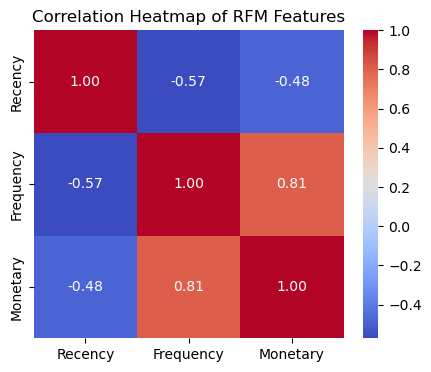

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = rfm_std.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of RFM Features")
plt.show()

**Plot To Figure Out The Data Distribution**

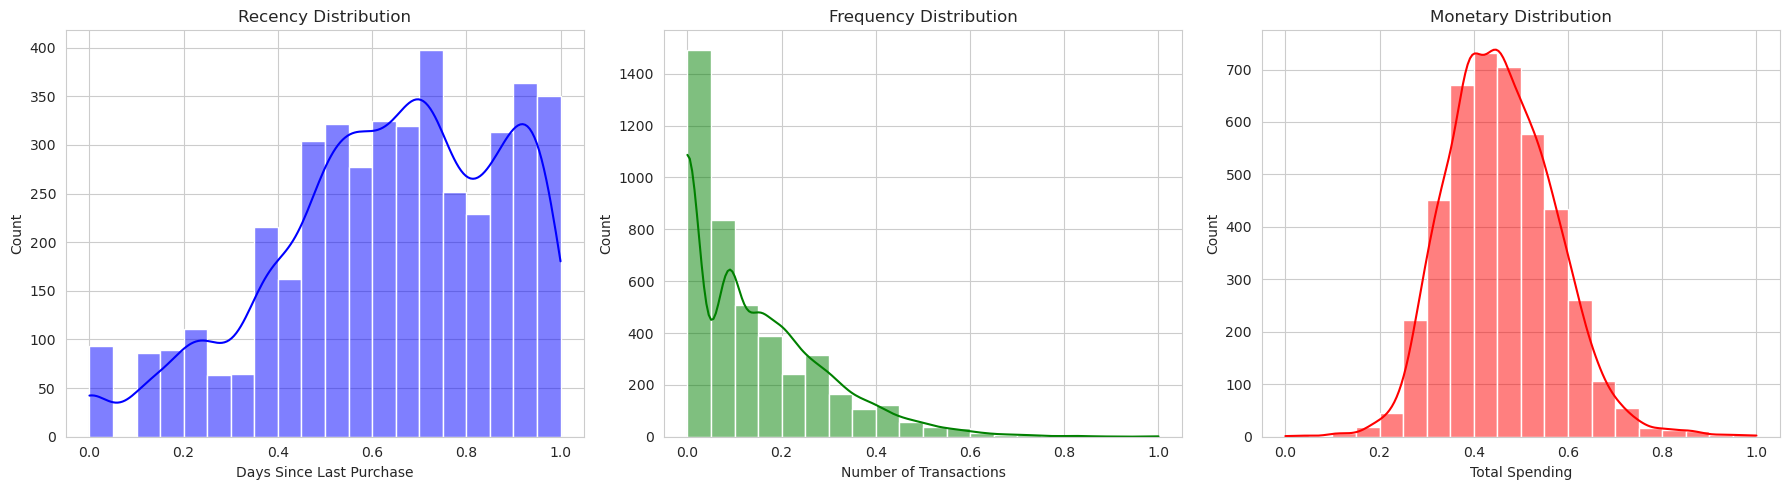

In [11]:
# style of the graph
sns.set_style("whitegrid")

# Subplots for each RFM feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Recency distribution
sns.histplot(rfm_std["Recency"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days Since Last Purchase")

# Plot Frequency distribution
sns.histplot(rfm_std["Frequency"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of Transactions")

# Plot Monetary distribution
sns.histplot(rfm_std["Monetary"], bins=20, kde=True, ax=axes[2], color="red")
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total Spending")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


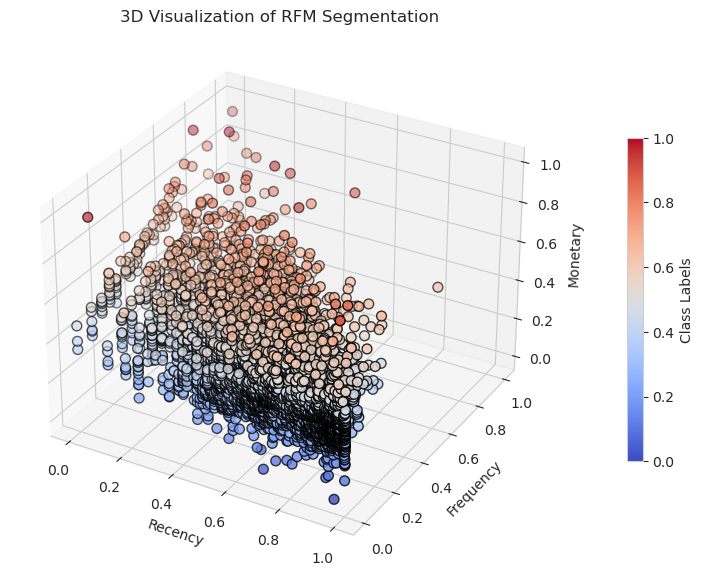

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Set the style
sns.set_style("whitegrid")

# Create the 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter= ax.scatter(rfm_std["Recency"], rfm_std["Frequency"], rfm_std["Monetary"],
           c=rfm_std["Monetary"], cmap="coolwarm", s=50, edgecolor='k')

# Labels and title
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Visualization of RFM Segmentation")

# Add color bar to indicate classes
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Class Labels")

# Show the plot
plt.show()


**Implement PCA Analysis**

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_std)

# Convert to DataFrame
rfm_df = pd.DataFrame(rfm_pca, columns=["Recency", "Frequency"])

**Using Elbow Method To find The Optimal Number Of Clusters**

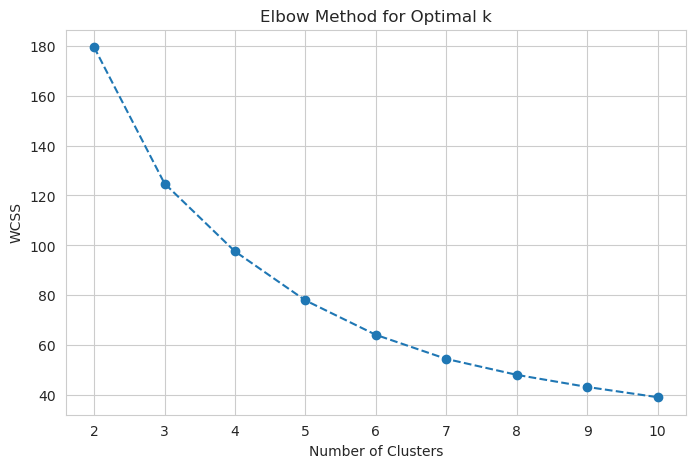

In [14]:
from sklearn.cluster import KMeans

# Initialize an empty list to store Within-Cluster Sum of Squares values
wcss = []

# Define the range of cluster numbers to test (from 2 to 10 clusters)
K_range = range(2, 11)

# Iterate over different values of k to find the optimal number of clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Initialize K-Means with k clusters
    kmeans.fit(rfm_df)  # Fit the model to the standardized RFM data
    wcss.append(kmeans.inertia_)  # Store the WCSS value for this k (lower is better)

plt.figure(figsize=(8, 5))

# Plot the WCSS values against the number of clusters
plt.plot(K_range, wcss, marker='o', linestyle='--')

# Label the axes
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

# Add a title to the plot
plt.title("Elbow Method for Optimal k")

# Display the plot
plt.show()


In [15]:
# !pip install kneed

**Optimal eps and min sample Selection for DBSCAN**

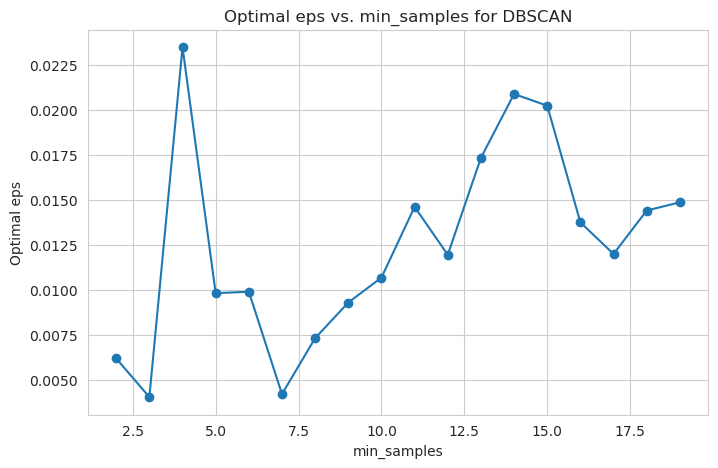

Optimal min_samples for DBSCAN: 4


In [16]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
import numpy as np


Features_rfm = rfm_df.iloc[:, 1:]
features_std = scaler.fit_transform(Features_rfm)

# Define a range of min_samples values to test
min_samples_values = range(2, 20)

# Store average k-distance for each min_samples
eps_values = []

for min_samples in min_samples_values:
    # Compute k-distances
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors.fit(features_std)
    distances, indices = neighbors.kneighbors(features_std)

    # Sort and take the k-th nearest distance
    sorted_distances = np.sort(distances[:, -1])

    # Find the knee (elbow point)
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    optimal_eps = sorted_distances[kneedle.elbow]

    eps_values.append(optimal_eps)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(min_samples_values, eps_values, marker="o")
plt.xlabel("min_samples")
plt.ylabel("Optimal eps")
plt.title("Optimal eps vs. min_samples for DBSCAN")
plt.grid(True)
plt.show()

# Print best min_samples value
best_min_samples = min_samples_values[np.argmax(eps_values)]
print(f"Optimal min_samples for DBSCAN: {best_min_samples}")


Optimal epsilon (eps) for DBSCAN: 0.023487576043984326


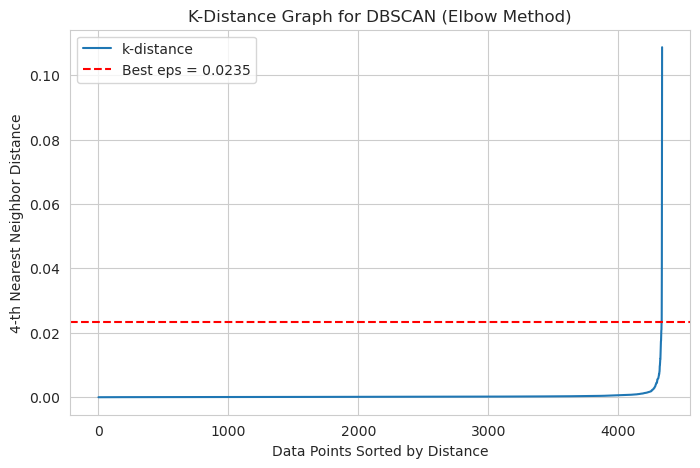

In [17]:
import numpy as np

# Set min_samples for DBSCAN
min_samples = 4

# Fit NearestNeighbors to find k-th nearest neighbor distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(features_std)
distances, indices = neighbors.kneighbors(features_std)

# Sort the distances (use only the k-th nearest neighbor distance)
distances = np.sort(distances[:, -1])

# Find the optimal eps using the KneeLocator (Elbow Method)
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
best_eps = distances[kneedle.elbow]  # Extract the best epsilon value

# Print the best eps
print(f"Optimal epsilon (eps) for DBSCAN: {best_eps}")

# Plot the k-distance graph with the elbow point
plt.figure(figsize=(8, 5))
plt.plot(distances, label="k-distance")
plt.axhline(y=best_eps, color='r', linestyle='--', label=f"Best eps = {best_eps:.4f}")
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN (Elbow Method)")
plt.legend()
plt.grid(True)
plt.show()


**ptimal Number of Clusters for GMM**

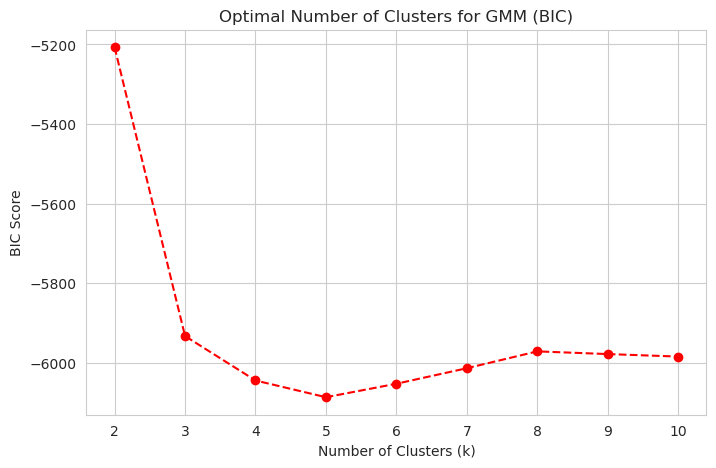

In [18]:
from sklearn.mixture import GaussianMixture

bic_scores = []  # Initialize an empty list to store BIC scores

for k in range(2, 11):  # Iterate over different numbers of clusters (from 2 to 10)
    gmm = GaussianMixture(n_components=k, random_state=42)  # Initialize Gaussian Mixture Model with k clusters
    gmm.fit(rfm_df)  # Fit the model to the RFM data
    bic_scores.append(gmm.bic(rfm_df))  # Compute and store the Bayesian Information Criterion (BIC) score


# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), bic_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("Optimal Number of Clusters for GMM (BIC)")
plt.show()


In [19]:
# !pip install pyclustering


In [20]:
from sklearn.cluster import SpectralClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.clique import clique

# Clustering Algorithms
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering(n_clusters=3, affinity='rbf', random_state=42),
    "BIRCH": Birch(n_clusters=3, threshold = 0.1),
    "DBSCAN": DBSCAN(eps=0.0235 , min_samples=4),
    "Gaussian Mixture Model": GaussianMixture(n_components=3, random_state=42),
    "CLIQUE": clique
}


In [21]:
from sklearn.preprocessing import StandardScaler

# Compute Clustering Results
cluster_results = {}
validation_scores = {}

# Fit each clustering model and store results
for name, algorithm in clustering_algorithms.items():
    if name == "CLIQUE":
        # CLIQUE instantiation
        clique_instance = clique(rfm_df.values.tolist(), 10, 2)
        clique_instance.process()
        clusters = clique_instance.get_clusters()

        # Assign labels manually
        labels = [-1] * len(rfm_df)  # Default label for noise points
        for cluster_id, cluster in enumerate(clusters):
            for idx in cluster:
                labels[idx] = cluster_id  # Assign each point to a cluster

    elif name == "DBSCAN":
        # Use scaled features for DBSCAN
        labels = algorithm.fit_predict(features_std)

    else:
        # Fit sklearn-compatible models with original features
        labels = algorithm.fit_predict(rfm_df)

    cluster_results[name] = labels  # Store cluster labels

# Now iterate over cluster_results (which is no longer empty)
for name, labels in cluster_results.items():
    unique_labels = set(labels)
    print(f"{name} - Unique Clusters Found: {len(unique_labels)}")


Spectral Clustering - Unique Clusters Found: 3
BIRCH - Unique Clusters Found: 3
DBSCAN - Unique Clusters Found: 3
Gaussian Mixture Model - Unique Clusters Found: 3
CLIQUE - Unique Clusters Found: 3


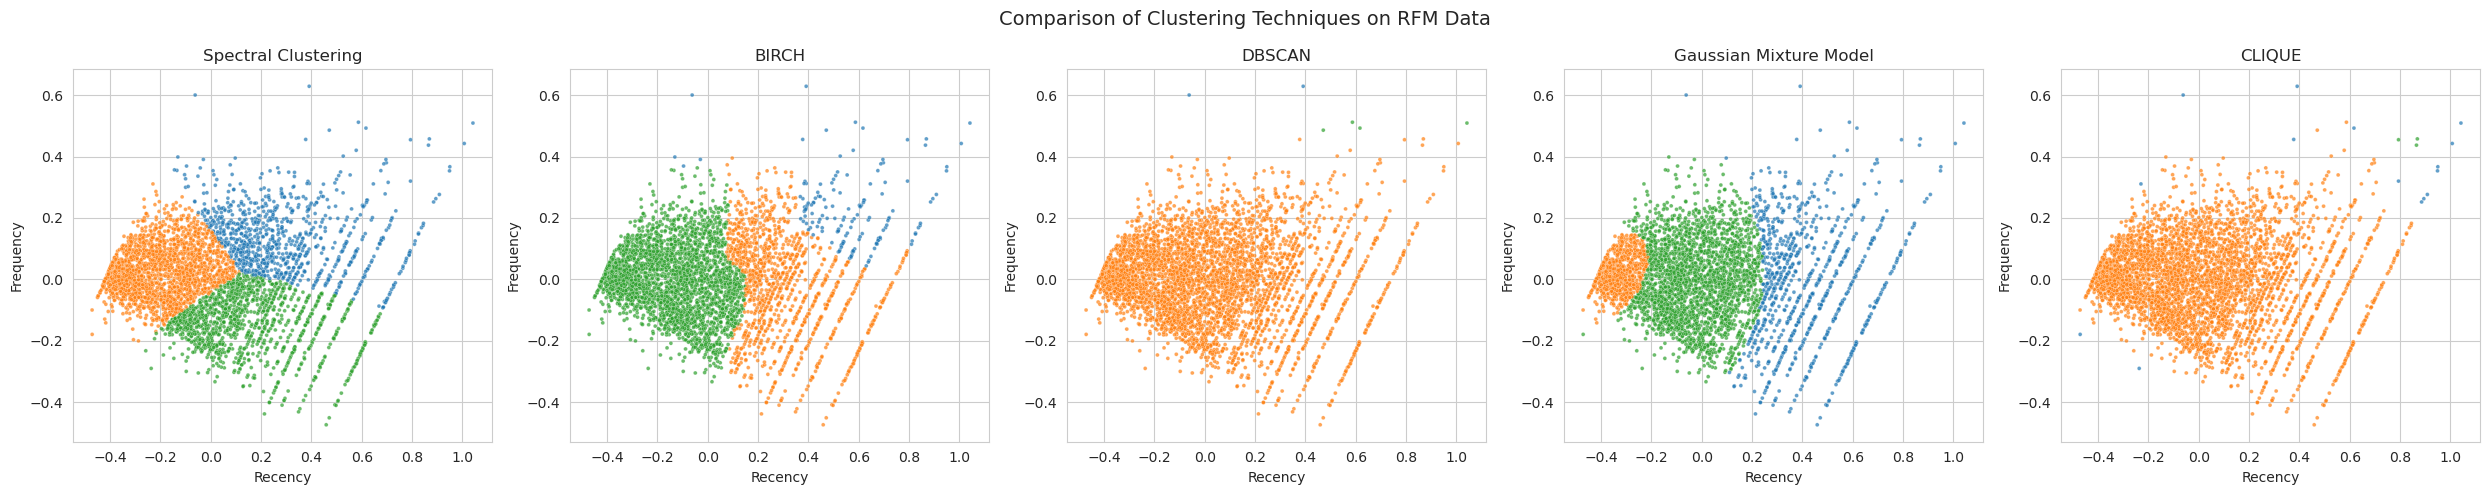

In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# Compute validation metrics for each clustering method
for name, labels in cluster_results.items():
    # Choose the correct dataset based on the clustering algorithm
    if name == "DBSCAN":
        data = features_std  # Use standardized features for DBSCAN
    else:
        data = rfm_df  # Use the RFM-normalized dataset for other clustering models

    # Compute clustering validation metrics only if there is more than one cluster
    if len(set(labels)) > 1:  # Silhouette Score requires at least 2 clusters
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = -1  # Assign -1 when only one cluster exists to avoid errors

    # Compute Davies-Bouldin Index (lower is better)
    db_index = davies_bouldin_score(data, labels)

    # Compute Calinski-Harabasz Index (higher is better)
    ch_index = calinski_harabasz_score(data, labels)

    # Store validation scores in a dictionary
    validation_scores[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

# Get the number of clustering methods used
num_clusters = len(cluster_results)

# Create subplots dynamically based on the number of clustering techniques
fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 5))
fig.suptitle("Comparison of Clustering Techniques on RFM Data", fontsize=14)

# If only one clustering method exists, make sure axes is iterable
if num_clusters == 1:
    axes = [axes]

# Iterate through the clustering results and visualize the clusters
for i, (name, labels) in enumerate(cluster_results.items()):
    unique_labels = len(set(labels))  # Get number of unique clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels)  # Define color palette

    # Scatter plot for visualizing clustering on Recency vs Frequency
    sns.scatterplot(
        x=rfm_df["Recency"],  # X-axis: Recency
        y=rfm_df["Frequency"],  # Y-axis: Frequency
        hue=labels,  # Color clusters by labels
        palette=palette,  # Use color palette based on unique labels
        alpha=0.7,  # Set transparency for better visibility
        s=8,  # Set point size
        ax=axes[i]  # Assign plot to the respective subplot
    )

    # Set plot title and axis labels
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Recency")
    axes[i].set_ylabel("Frequency")

    # Remove legends from each subplot to avoid redundancy
    axes[i].legend([], frameon=False)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plots
plt.show()


In [23]:
# Convert validation scores to DataFrame
validation_df = pd.DataFrame(validation_scores).T

# Print the validation scores
validation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
Spectral Clustering,0.367562,1.094232,3256.713999
BIRCH,0.412376,0.960527,2864.828408
DBSCAN,0.679162,0.220568,52.031006
Gaussian Mixture Model,0.339706,0.849060,3828.985990
CLIQUE,0.532826,1.445112,47.537802
